<a href="https://colab.research.google.com/github/mattocanas/XGBoost-Enzyme-Stability-Pred/blob/main/XGBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# DEFINE WHAT TO TRAIN WITH (and KFOLD VALIDATE) VERSUS HOLDOUT VALIDATE WITH
# ADD WORDS "kaggle.csv", "jin_tm.csv", "jin_train.csv", "jin_test.csv" to lists below
# IF YOU ADD MORE DATASETS, ADD THOSE WORDS TOO

KFOLD_SOURCES = ['jin_tm.csv','jin_train.csv','jin_test.csv']
HOLDOUT_SOURCES = ['kaggle.csv']

# IF WILD TYPE GROUP HAS FEWER THAN THIS MANY MUTATION ROWS REMOVE THEM
EXCLUDE_CT_UNDER = 25

# IF WE TRAIN WITH ALPHA FOLD'S PDBS WE MUST INFER WITH "PLDDT = TRUE"
# KAGGLE.CSV USES ALPHA FOLD PDB, SO SET BELOW TO TRUE WHEN TRAIN WITH KAGGLE.CSV
# JIN.CSV EXTERNAL DATA USES PROTEIN DATA BANK, SO SET BELOW TO FALSE WITH JIN DATA
USE_PLDDT_INFER = False

# IF WE WISH TO TRAIN WITH MIXTURE OF ALPHA FOLD AND PROTEIN DATA BANK PDB FILES
# THEN WE CAN EXCLUDE B_COLUMN AND THEN THERE IS NO PROBLEM
USE_B_COLUMN = False

VER = 17

In [ ]:
import os, numpy as np, gc, seaborn as sns
from scipy.stats import spearmanr, pearsonr, rankdata
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.max_columns', 500)

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/JinyuanSun/mutation-stability-data/main/v1/train.csv')
df = df.iloc[:,1:]
print('Downloaded train shape', df.shape )
df.head()

Downloaded train shape (3839, 7)


,PDB,wildtype,position,mutation,ddG,sequence,mutant_seq
0,1A5E,L,121,R,0.66,MEPAAGSSMEPSADWLATAAARGRVEEVRALLEAGALPNAPNSYGR...,MEPAAGSSMEPSADWLATAAARGRVEEVRALLEAGALPNAPNSYGR...
1,1A5E,L,37,S,0.71,MEPAAGSSMEPSADWLATAAARGRVEEVRALLEAGALPNAPNSYGR...,MEPAAGSSMEPSADWLATAAARGRVEEVRALLEAGASPNAPNSYGR...
2,1A5E,W,15,D,0.17,MEPAAGSSMEPSADWLATAAARGRVEEVRALLEAGALPNAPNSYGR...,MEPAAGSSMEPSADDLATAAARGRVEEVRALLEAGALPNAPNSYGR...
3,1A5E,D,74,N,-2.00,MEPAAGSSMEPSADWLATAAARGRVEEVRALLEAGALPNAPNSYGR...,MEPAAGSSMEPSADWLATAAARGRVEEVRALLEAGALPNAPNSYGR...
4,1A5E,P,81,L,0.00,MEPAAGSSMEPSADWLATAAARGRVEEVRALLEAGALPNAPNSYGR...,MEPAAGSSMEPSADWLATAAARGRVEEVRALLEAGALPNAPNSYGR...


In [ ]:
df2 = pd.read_csv('https://raw.githubusercontent.com/JinyuanSun/mutation-stability-data/main/v1/test.csv')
df2 = df2.iloc[:,1:]
print('Downloaded test shape', df2.shape )
df2.head()

Downloaded test shape (259, 7)


,PDB,wildtype,position,mutation,ddG,sequence,mutant_seq
0,2PTL,L,24,A,-2.939771,ENKEETPETPETDSEEEVTIKANLIFANGSTQTAEFKGTFEKATSE...,ENKEETPETPETDSEEEVTIKANAIFANGSTQTAEFKGTFEKATSE...
1,2PTL,F,36,A,-4.851816,ENKEETPETPETDSEEEVTIKANLIFANGSTQTAEFKGTFEKATSE...,ENKEETPETPETDSEEEVTIKANLIFANGSTQTAEAKGTFEKATSE...
2,2PTL,A,51,G,-3.274379,ENKEETPETPETDSEEEVTIKANLIFANGSTQTAEFKGTFEKATSE...,ENKEETPETPETDSEEEVTIKANLIFANGSTQTAEFKGTFEKATSE...
3,2PTL,V,65,A,-1.099426,ENKEETPETPETDSEEEVTIKANLIFANGSTQTAEFKGTFEKATSE...,ENKEETPETPETDSEEEVTIKANLIFANGSTQTAEFKGTFEKATSE...
4,2PTL,I,74,V,-0.167304,ENKEETPETPETDSEEEVTIKANLIFANGSTQTAEFKGTFEKATSE...,ENKEETPETPETDSEEEVTIKANLIFANGSTQTAEFKGTFEKATSE...


In [ ]:
df3 = pd.read_csv('https://raw.githubusercontent.com/JinyuanSun/mutation-stability-data/main/v1/tm.csv')
df3 = df3.iloc[:,1:]
print('Downloaded tm shape', df3.shape )
df3.head()

Downloaded tm shape (998, 7)


,PDB,WT,position,MUT,dTm,sequence,mutant_seq
0,1CQW,V,245,L,2.1,MSEIGTGFPFDPHYVEVLGERMHYVDVGPRDGTPVLFLHGNPTSSY...,MSEIGTGFPFDPHYVEVLGERMHYVDVGPRDGTPVLFLHGNPTSSY...
1,1CQW,L,95,V,-0.4,MSEIGTGFPFDPHYVEVLGERMHYVDVGPRDGTPVLFLHGNPTSSY...,MSEIGTGFPFDPHYVEVLGERMHYVDVGPRDGTPVLFLHGNPTSSY...
2,1CQW,C,176,F,5.2,MSEIGTGFPFDPHYVEVLGERMHYVDVGPRDGTPVLFLHGNPTSSY...,MSEIGTGFPFDPHYVEVLGERMHYVDVGPRDGTPVLFLHGNPTSSY...
3,1CQW,G,171,Q,3.1,MSEIGTGFPFDPHYVEVLGERMHYVDVGPRDGTPVLFLHGNPTSSY...,MSEIGTGFPFDPHYVEVLGERMHYVDVGPRDGTPVLFLHGNPTSSY...
4,1CQW,T,148,L,1.1,MSEIGTGFPFDPHYVEVLGERMHYVDVGPRDGTPVLFLHGNPTSSY...,MSEIGTGFPFDPHYVEVLGERMHYVDVGPRDGTPVLFLHGNPTSSY...


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### What is going on below???

This is kind of hard to explain. Essentially, the Kaggle training data simply has one protein sequence. But in order to find patterns relevtant to the test set which has a wildtype and single mutatuion variant, we need to find variants of each protein in the train set.

This was already done on Kggle by Robert Hatch. There are 78 different wildtype proteins in this set. And 4195 total pairs of wildtype-single mutants.

We will filter this below. From each group involving one wild type, we will only keep the rows from the most common data_source and pH pair. Furthermore, we remove rows belonging to a single data_source pH pair where all Tm targets are the same. And we remove 4 out of 78 groups where GreySnow and Vladimir did not find the PDB file.

In [ ]:
kaggle = pd.read_csv("/content/drive/My Drive/novozymes-enzyme-stability-prediction 4/train_wildtype_groups.csv")
print('Before processing Robert dataframe shape:', kaggle.shape )
kaggle.head()
kaggle['id'] = kaggle.data_source.astype('str') + '_' + kaggle.pH.astype('str') + '_' + kaggle.group.astype('str')
kaggle['ct'] = kaggle.groupby('id').id.transform('count')
kaggle['n'] = kaggle.groupby('id').tm.transform('nunique')
kaggle = kaggle.loc[kaggle.n>1]
kaggle = kaggle.sort_values(['group','ct'],ascending=[True,False])
KEEP = kaggle.groupby('group').id.agg('first').values
kaggle = kaggle.loc[kaggle.id.isin(KEEP)]
kaggle.head()


Before processing Robert dataframe shape: (4195, 8)


,seq_id,protein_sequence,pH,data_source,tm,x,group,wildtype,id,ct,n
49,18324,MNIFEMLRIDERLRLKIYKDTEGYYTAGIGHLLTKSPSLNAAKSEL...,3.0,NaN,44.0,164,0,MNIFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,nan_3.0_0,35,4
52,18327,MNIFEMLRIDERLRLKIYKDTEGYYTIAIGHLLTKSPSLNAAKSEL...,3.0,NaN,52.0,164,0,MNIFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,nan_3.0_0,35,4
53,18328,MNIFEMLRIDERLRLKIYKDTEGYYTIGAGHLLTKSPSLNAAKSEL...,3.0,NaN,44.0,164,0,MNIFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,nan_3.0_0,35,4
92,18372,MNIFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKCEL...,3.0,NaN,52.0,164,0,MNIFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,nan_3.0_0,35,4
94,18374,MNIFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKDEL...,3.0,NaN,52.0,164,0,MNIFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,nan_3.0_0,35,4


### Helper Function
This function below compares the mutated sequence to the woldtype sequence and gives information regarding the mutation into that row of the DF
* wildtype residue -> WT
* mutated residue -> MUT
* position of mutation -> position

In [ ]:
def find_mut(row):
    mut = row.protein_sequence
    seq = row.wildtype
    same = True
    for i,(x,y) in enumerate(zip(seq,mut)):
        if x!=y: 
            same = False
            break
    if not same:
        row['WT'] = seq[i]
        row['position'] = i+1
        row['MUT'] = mut[i]
    else:
        row['WT'] = 'X'
        row['position'] = -1   
        row['MUT'] = 'X'     
    return row

The code below gives each group its own "PDB" number.
If then applied the `find_mut` function across all the rows. It then gets rid of any deletions I beleive. It then finds a base Tm for that whole group, which is just the mean Tm of that group. It then gives each row a dTM values which is that rows Tm minus its groups Tm. Lastly, it renames some rows.

In [ ]:
grp = [f'GP{g:02d}' for g in kaggle.group.values]
kaggle['PDB'] = grp
kaggle = kaggle.apply(find_mut,axis=1)
kaggle = kaggle.loc[kaggle.position!=-1]
kaggle['base'] = kaggle.groupby('group').tm.transform('mean')
kaggle['dTm'] = kaggle.tm - kaggle.base
kaggle = kaggle.rename({'wildtype':'sequence','protein_sequence':'mutant_seq'},axis=1)
COLS = ['PDB','WT','position','MUT','dTm','sequence','mutant_seq']
kaggle = kaggle[COLS]
kaggle.head()

,PDB,WT,position,MUT,dTm,sequence,mutant_seq
49,GP00,I,27,A,-6.477143,MNIFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,MNIFEMLRIDERLRLKIYKDTEGYYTAGIGHLLTKSPSLNAAKSEL...
52,GP00,G,28,A,1.522857,MNIFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,MNIFEMLRIDERLRLKIYKDTEGYYTIAIGHLLTKSPSLNAAKSEL...
53,GP00,I,29,A,-6.477143,MNIFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,MNIFEMLRIDERLRLKIYKDTEGYYTIGAGHLLTKSPSLNAAKSEL...
92,GP00,S,44,C,1.522857,MNIFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,MNIFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKCEL...
94,GP00,S,44,D,1.522857,MNIFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,MNIFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKDEL...


Import alphafold data from https://www.kaggle.com/datasets/shlomoron/train-wildtypes-af

Discussion here: https://www.kaggle.com/competitions/novozymes-enzyme-stability-prediction/discussion/359284

In [ ]:
alphafold = pd.read_csv("/content/drive/My Drive/novozymes-enzyme-stability-prediction 4/alpha_fold_df.csv")

The code below creates and empty dictionary.
* it then enumerates through all the sequences in the kaggle df and if that sequence matches the sequence in the alphafold dataset, then that row from the kaggle set is given a new column named CIF that has the af2id. This is the alphafold id
* It drops any sequence without an alphafold id

In [ ]:
dd = {}
for s in kaggle.sequence.unique():
    tmp = alphafold.loc[alphafold.af2_sequence==s,'af2id']
    if len(tmp)>0: c = tmp.values[0].split(':')[1]
    else: c = np.nan
    dd[s] = c
    
kaggle['CIF'] = kaggle.sequence.map(dd)
kaggle = kaggle.loc[kaggle.CIF.notnull()].reset_index(drop=True)
kaggle.to_csv('kaggle_train.csv',index=False)
print('After processing Robert dataframe shape:', kaggle.shape )
kaggle.head()

After processing Robert dataframe shape: (1737, 8)


,PDB,WT,position,MUT,dTm,sequence,mutant_seq,CIF
0,GP01,T,95,C,1.297838,MLVMTEYLLSAGICMAIVSILLIGMAISNVSKGQYAKRFFFFATSC...,MLVMTEYLLSAGICMAIVSILLIGMAISNVSKGQYAKRFFFFATSC...,AF-P00644-F1
1,GP01,T,95,C,0.097838,MLVMTEYLLSAGICMAIVSILLIGMAISNVSKGQYAKRFFFFATSC...,MLVMTEYLLSAGICMAIVSILLIGMAISNVSKGQYAKRFFFFATSC...,AF-P00644-F1
2,GP01,T,95,S,2.297838,MLVMTEYLLSAGICMAIVSILLIGMAISNVSKGQYAKRFFFFATSC...,MLVMTEYLLSAGICMAIVSILLIGMAISNVSKGQYAKRFFFFATSC...,AF-P00644-F1
3,GP01,T,95,S,3.697838,MLVMTEYLLSAGICMAIVSILLIGMAISNVSKGQYAKRFFFFATSC...,MLVMTEYLLSAGICMAIVSILLIGMAISNVSKGQYAKRFFFFATSC...,AF-P00644-F1
4,GP01,T,104,C,2.397838,MLVMTEYLLSAGICMAIVSILLIGMAISNVSKGQYAKRFFFFATSC...,MLVMTEYLLSAGICMAIVSILLIGMAISNVSKGQYAKRFFFFATSC...,AF-P00644-F1


### Combine the 4 CSV Files

In [ ]:
df['source'] = 'jin_train.csv'
df['dTm'] = np.nan
df['CIF'] = None
df2['source'] = 'jin_test.csv'
df2['dTm'] = np.nan
df2['CIF'] = None

df3 = df3.loc[~df3.PDB.isin(['1RX4', '2LZM', '3MBP'])].copy()
df3['source'] = 'jin_tm.csv'
df3['ddG'] = np.nan
df3['CIF'] = None
df3 = df3.rename({'WT':'wildtype','MUT':'mutation'},axis=1)
df3 = df3[df.columns]

kaggle['source'] = 'kaggle.csv'
kaggle['ddG'] = np.nan
kaggle = kaggle.rename({'WT':'wildtype','MUT':'mutation'},axis=1)
kaggle = kaggle[df.columns]

df = pd.concat([df,df2,df3,kaggle],axis=0,ignore_index=True)
del df2, df3, kaggle
print('Combined data shape',df.shape)
df.to_csv(f'all_train_data_v{VER}.csv',index=False)
df = df.loc[df.source.isin(KFOLD_SOURCES+HOLDOUT_SOURCES)]
print('Kfold plus Holdout shape',df.shape)
df = df.sort_values(['PDB','position']).reset_index(drop=True)
df.head()

Combined data shape (6809, 10)
Kfold plus Holdout shape (6809, 10)


,PDB,wildtype,position,mutation,ddG,sequence,mutant_seq,source,dTm,CIF
0,1A43,G,9,A,-1.0,TSILDIRQGPKEPFRDYVDRFYKTLRAEQASQEVKNWMTETLLVQN...,TSILDIRQAPKEPFRDYVDRFYKTLRAEQASQEVKNWMTETLLVQN...,jin_train.csv,NaN,None
1,1A43,E,12,D,-2.1,TSILDIRQGPKEPFRDYVDRFYKTLRAEQASQEVKNWMTETLLVQN...,TSILDIRQGPKDPFRDYVDRFYKTLRAEQASQEVKNWMTETLLVQN...,jin_train.csv,NaN,None
2,1A43,R,20,A,-3.0,TSILDIRQGPKEPFRDYVDRFYKTLRAEQASQEVKNWMTETLLVQN...,TSILDIRQGPKEPFRDYVDAFYKTLRAEQASQEVKNWMTETLLVQN...,jin_train.csv,NaN,None
3,1A43,W,37,A,-0.7,TSILDIRQGPKEPFRDYVDRFYKTLRAEQASQEVKNWMTETLLVQN...,TSILDIRQGPKEPFRDYVDRFYKTLRAEQASQEVKNAMTETLLVQN...,jin_train.csv,NaN,None
4,1A43,C,71,S,-2.3,TSILDIRQGPKEPFRDYVDRFYKTLRAEQASQEVKNWMTETLLVQN...,TSILDIRQGPKEPFRDYVDRFYKTLRAEQASQEVKNWMTETLLVQN...,jin_train.csv,NaN,None


## Download 200 PDB Files

In [ ]:
print('There are',df.PDB.nunique(),'PDB files to download')

There are 290 PDB files to download


In [ ]:
# THE FOLLOWING PROTEINS SEQUENCES CANNOT BE ALIGNED BETWEEN CSV AND PDB FILE (not sure why)
bad = [f for f in df.PDB.unique() if len(f)>4]
bad += ['1LVE', '2IMM', '2RPN', '1BKS', '1BLC', '1D5G', '1KDX', '1OTR', '3BN0', '3D3B', '3HHR', '3O39']
bad += ['3BDC','1AMQ','1X0J','1TPK','1GLM','1RHG','3DVI','1RN1','1QGV'] 
bad += ['1SVX','4E5K'] 
print(f'We will ignore mutations from {len(bad)} PDB files')

We will ignore mutations from 32 PDB files


In [ ]:
os.system('mkdir downloaded_pdb')
for p in [f for f in df.PDB.unique() if f not in bad]:
    if p[:2]=='GP': continue # skip kaggle CIF
    os.system(f'cd downloaded_pdb; wget https://files.rcsb.org/download/{p}.pdb') 

# Feature Engineering
This notebook uses 5 features for prediction:
* protein structure
* protein sequence
* amino acids
* substitution matrix
* transformer ESM embeddings

## Protein Structure Feature

In [ ]:
!pip install py3Dmol -q
import py3Dmol 

In [ ]:
with open("/content/drive/My Drive/novozymes-enzyme-stability-prediction 4/wildtype_structure_prediction_af2.pdb") as ifile:
    protein = "".join([x for x in ifile])

In [ ]:
view = py3Dmol.view(width=800, height=600) 
view.addModelsAsFrames(protein)
style = {'cartoon': {'color': 'spectrum'},'stick':{}}
view.setStyle({'model': -1},style) 
view.zoom(0.12)
view.rotate(235, {'x':0,'y':1,'z':1})
# view.spin({'x':-0.2,'y':0.5,'z':1},1)
view.show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

## Amino Acid Features

In [ ]:
# BIOPANDAS PDB READER
!pip install biopandas -q
from biopandas.pdb import PandasPdb
from biopandas.mmcif import PandasMmcif
aa_map = {'VAL': 'V', 'PRO': 'P', 'ASN': 'N', 'GLU': 'E', 'ASP': 'D', 'ALA': 'A', 'THR': 'T', 'SER': 'S',
          'LEU': 'L', 'LYS': 'K', 'GLY': 'G', 'GLN': 'Q', 'ILE': 'I', 'PHE': 'F', 'CYS': 'C', 'TRP': 'W',
          'ARG': 'R', 'TYR': 'Y', 'HIS': 'H', 'MET': 'M'}
aa_map_2 = {x:y for x,y in zip(np.sort(list(aa_map.values())),np.arange(20))}
aa_map_2['X'] = 20

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 879.0/879.0 KB 13.1 MB/s eta 0:00:00


In [ ]:
aa_map_2

{'A': 0,
 'C': 1,
 'D': 2,
 'E': 3,
 'F': 4,
 'G': 5,
 'H': 6,
 'I': 7,
 'K': 8,
 'L': 9,
 'M': 10,
 'N': 11,
 'P': 12,
 'Q': 13,
 'R': 14,
 'S': 15,
 'T': 16,
 'V': 17,
 'W': 18,
 'Y': 19,
 'X': 20}

In [ ]:
aa_props = pd.read_csv("/content/drive/My Drive/novozymes-enzyme-stability-prediction 4/aminoacids.csv").set_index('Letter')

In [ ]:
PROPS = ['Molecular Weight', 'Residue Weight', 'pKa1', 'pKb2', 'pKx3', 'pl4', 
         'H', 'VSC', 'P1', 'P2', 'SASA', 'NCISC']
print('Amino Acid properties dataframe. Shape:', aa_props.shape )
aa_props.head(22)

Amino Acid properties dataframe. Shape: (22, 21)


,Name,Abbr,Molecular Weight,Molecular Formula,Residue Formula,Residue Weight,pKa1,pKb2,pKx3,pl4,H,VSC,P1,P2,SASA,NCISC,carbon,hydrogen,nitrogen,oxygen,sulfur
Letter,,,,,,,,,,,,,,,,,,,,,
A,Alanine,Ala,89.10,C3H7NO2,C3H5NO,71.08,2.34,9.69,NaN,6.00,0.62,27.5,8.1,0.046,1.181,0.007187,3,7,1,2,0
C,Cysteine,Cys,121.16,C3H7NO2S,C3H5NOS,103.15,1.96,10.28,8.18,5.07,0.29,44.6,5.5,0.128,1.461,-0.036610,3,7,1,2,1
D,Aspartic acid,Asp,133.11,C4H7NO4,C4H5NO3,115.09,1.88,9.60,3.65,2.77,-0.90,40.0,13.0,0.105,1.587,-0.023820,4,7,1,4,0
E,Glutamic acid,Glu,147.13,C5H9NO4,C5H7NO3,129.12,2.19,9.67,4.25,3.22,-0.74,62.0,12.3,0.151,1.862,0.006802,5,9,1,4,0
F,Phenylalanine,Phe,165.19,C9H11NO2,C9H9NO,147.18,1.83,9.13,NaN,5.48,1.19,115.5,5.2,0.290,2.228,0.037552,9,11,1,2,0
G,Glycine,Gly,75.07,C2H5NO2,C2H3NO,57.05,2.34,9.60,NaN,5.97,0.48,0.0,9.0,0.000,0.881,0.179052,2,5,1,2,0
H,Histidine,His,155.16,C6H9N3O2,C6H7N3O,137.14,1.82,9.17,6.00,7.59,-0.40,79.0,10.4,0.230,2.025,-0.010690,6,9,3,2,0
I,Isoleucine,Ile,131.18,C6H13NO2,C6H11NO,113.16,2.36,9.60,NaN,6.02,1.38,93.5,5.2,0.186,1.810,0.021631,6,13,1,2,0
K,Lysine,Lys,146.19,C6H14N2O2,C6H12N2O,128.18,2.18,8.95,10.53,9.74,-1.50,100.0,11.3,0.219,2.258,0.017708,6,14,2,2,0


## Substitution Matrix Features
Adding features from Blosum and DeMaSk substitution matrices. DeMaSk matrix was downloaded from here: https://demask.princeton.edu/about/


In [ ]:
!pip install biopython==1.78
# BLOSUM SUBSTITUTION MATRICES
from Bio.SubsMat import MatrixInfo
def get_sub_matrix(matrix_name="blosum100"):
    sub_matrix = getattr(MatrixInfo, matrix_name)
    sub_matrix.update({(k[1], k[0]):v for k,v in sub_matrix.items() if (k[1], k[0]) not in list(sub_matrix.keys())})
    return sub_matrix
sub_mat_b100 = get_sub_matrix("blosum100")
sub_mat_b80 = get_sub_matrix("blosum80")
sub_mat_b60 = get_sub_matrix("blosum60")
sub_mat_b40 = get_sub_matrix("blosum40")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 15.2 MB/s eta 0:00:00


/usr/local/lib/python3.8/dist-packages/Bio/SubsMat/__init__.py:126: BiopythonDeprecationWarning: Bio.SubsMat has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.substitution_matrices as a replacement, and contact the Biopython developers if you still need the Bio.SubsMat module.
  warnings.warn(


In [ ]:
# DEMASK SUBSTITUTION MATRICES
dff = pd.read_csv("/content/drive/My Drive/novozymes-enzyme-stability-prediction 4/matrix.txt", sep='\t')
letters = list( dff.columns )
l_dict = {x:y for x,y in zip(letters,range(20))}
sub_mat_demask = {}
for x in letters:
    for y in letters:
        sub_mat_demask[(x,y)] = dff.iloc[l_dict[x],l_dict[y]]



In [ ]:
# PLOT MATRICES
AA = np.sort(list(aa_map.values()))
blosum100 = np.zeros((20,20))
demask = np.zeros((20,20))
for (k1,k2),v in sub_mat_b100.items():
    if (k1!='Z')&(k2!='Z')&(k1!='B')&(k2!='B')&(k1!='X')&(k2!='X'):
        blosum100[ aa_map_2[k1], aa_map_2[k2] ] = v
for (k1,k2),v in sub_mat_demask.items():
    if (k1!='Z')&(k2!='Z')&(k1!='B')&(k2!='B')&(k1!='X')&(k2!='X'):
        demask[ aa_map_2[k1], aa_map_2[k2] ] = v

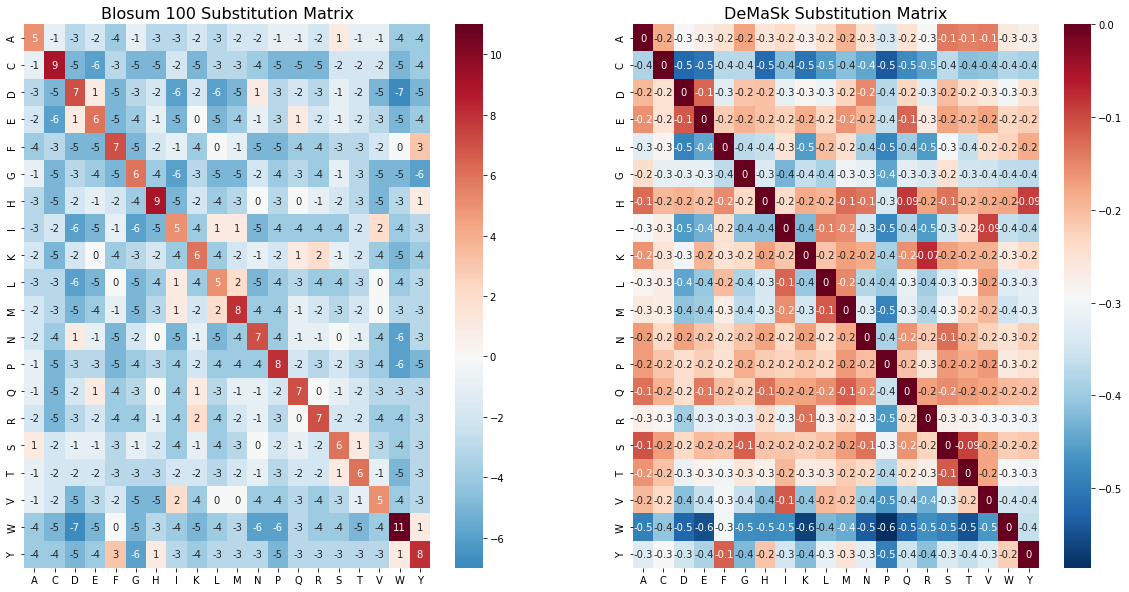

In [ ]:
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
sns.heatmap(blosum100, cmap='RdBu_r', annot=True, center=0.0)
plt.xticks(np.arange(20)+0.5,AA)
plt.yticks(np.arange(20)+0.5,AA)
plt.title('Blosum 100 Substitution Matrix',size=16)
plt.subplot(1,2,2)
sns.heatmap(demask, cmap='RdBu_r', annot=True, fmt='.1g') #, center=0.0)
plt.xticks(np.arange(20)+0.5,AA)
plt.yticks(np.arange(20)+0.5,AA)
plt.title('DeMaSk Substitution Matrix',size=16)
plt.show()

## Transformer ESM Features

In [ ]:
# https://github.com/facebookresearch/esm
!pip install fair-esm -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.1/93.1 KB 3.0 MB/s eta 0:00:00


In [ ]:
# https://www.kaggle.com/code/kaggleqrdl/esm-quick-start-lb237
import torch, esm
token_map = {'L': 0, 'A': 1, 'G': 2, 'V': 3, 'S': 4, 'E': 5, 'R': 6, 'T': 7, 'I': 8, 'D': 9, 'P': 10, 
         'K': 11, 'Q': 12, 'N': 13, 'F': 14, 'Y': 15, 'M': 16, 'H': 17, 'W': 18, 'C': 19}
t_model, alphabet = esm.pretrained.esm2_t33_650M_UR50D()
batch_converter = alphabet.get_batch_converter()
t_model.eval()  # disables dropout for deterministic results
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
t_model.to(device)

Downloading: "https://dl.fbaipublicfiles.com/fair-esm/models/esm2_t33_650M_UR50D.pt" to /root/.cache/torch/hub/checkpoints/esm2_t33_650M_UR50D.pt
Downloading: "https://dl.fbaipublicfiles.com/fair-esm/regression/esm2_t33_650M_UR50D-contact-regression.pt" to /root/.cache/torch/hub/checkpoints/esm2_t33_650M_UR50D-contact-regression.pt


ESM2(
  (embed_tokens): Embedding(33, 1280, padding_idx=1)
  (layers): ModuleList(
    (0): TransformerLayer(
      (self_attn): MultiheadAttention(
        (k_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (v_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (q_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (out_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (rot_emb): RotaryEmbedding()
      )
      (self_attn_layer_norm): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
      (fc1): Linear(in_features=1280, out_features=5120, bias=True)
      (fc2): Linear(in_features=5120, out_features=1280, bias=True)
      (final_layer_norm): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
    )
    (1): TransformerLayer(
      (self_attn): MultiheadAttention(
        (k_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (v_proj): Linear(in_features=1280, out_features=1280, bia

### Embeddings

In [ ]:
# TRAIN AND TEST WILDTYPES
PCA_CT = 16 # random sample size per protein to fit PCA with
all_pdb = [f for f in df.PDB.unique() if f not in bad]
base = 'VPVNPEPDATSVENVALKTGSGDSQSDPIKADLEVKGQSALPFDVDCWAILCKGAPNVLQRVNEKTKNSNRDRSGANKGPFKDPQKWGIKALPPKNPSWSAQDFKSPEEYAFASSLQGGTNAILAPVNLASQNSQGGVLNGFYSANKVAQFDPSKPQQTKGTWFQITKFTGAAGPYCKALGSNDKSVCDKNKNIAGDWGFDPAKWAYQYDEKNNKFNYVGK'
all_pdb_embed_pool = np.zeros((len(all_pdb)+1,1280))
all_pdb_embed_local = []
all_pdb_embed_tmp = []

In [ ]:
from scipy.special import softmax 
from scipy.stats import entropy
all_pdb_prob = []

In [ ]:
# EXTRACT TRANSFORMER EMBEDDINGS FOR TRAIN AND TEST WILDTYPES
print('Extracting embeddings from proteins...')
for i,p in enumerate(all_pdb+['TEST']):
    
    # WILDTYPE SEQUENCE
    print(p,', ',end='')
    if p=='TEST': seq = base
    else: seq = df.loc[df.PDB==p,'sequence'].iloc[0]
        
    # EXTRACT EMBEDDINGS, MUTATION PROBABILITIES, ENTROPY
    data = [("protein1", seq)]
    batch_labels, batch_strs, batch_tokens = batch_converter(data)
    batch_tokens = batch_tokens.to(device)
    with torch.no_grad():
        results = t_model(batch_tokens, repr_layers=[33])
    logits = (results['logits'].detach().cpu().numpy()[0,].T)[4:24,1:-1]
    all_pdb_prob.append(softmax(logits,axis=0))
    results = results["representations"][33].detach().cpu().numpy()
    
    # SAVE EMBEDDINGS
    all_pdb_embed_local.append(results)
    all_pdb_embed_pool[i,] = np.mean( results[0,:,:],axis=0 )
    
    # TEMPORARILY SAVE LOCAL MUTATION EMBEDDINGS
    tmp = df.loc[df.PDB==p,'position'].unique()
    if p=='TEST': tmp = np.random.choice(range(20,200),PCA_CT,replace=False)
    if len(tmp)>PCA_CT: tmp = np.random.choice(tmp,PCA_CT,replace=False)
    for j in tmp: all_pdb_embed_tmp.append( results[0,j,:] )
        
    del batch_tokens, results
    gc.collect(); torch.cuda.empty_cache()

all_pdb_embed_tmp = np.stack(all_pdb_embed_tmp)

Extracting embeddings from proteins...
1A43 , 1A5E , 1A7C , 1AAR , 1AG2 , 1AJ3 , 1AKK , 1AM7 , 1ANK , 1APS , 1ARR , 1AXB , 1AYF , 1AYI , 1AZP , 1B0O , 1B10 , 1BFG , 1BFM , 1BNI , 1BP2 , 1BPI , 1BTA , 1BU4 , 1BVC , 1BYW , 1C2R , 1C9O , 1CDC , 1CF3 , 1CHK , 1CQW , 1CSP , 1CYC , 1DIL , 1DIV , 1DKT , 1FKJ , 1FRD , 1FTG , 1FXA , 1G6N , 1G6P , 1H0C , 1H0X , 1H56 , 1H7M , 1HFY , 1HFZ , 1HME , 1HNG , 1HTI , 1HUE , 1IGV , 1IHB , 1IMQ , 1IO2 , 1IOB , 1IRO , 1ITM , 1JY0 , 1K5U , 1K9Q , 1KCQ , 1KFW , 1LS4 , 1LZ1 , 1M21 , 1M7T , 1MBG , 1MGR , 1MJ5 , 1MJC , 1MSI , 1N18 , 1N88 , 1NVO , 1O1U , 1OH0 , 1OIA , 1ONC , 1P2P , 1PDO , 1PFL , 1POH , 1PX0 , 1QGD , 1QLP , 1QM0 , 1QND , 1QQV , 1REI , 1RGG , 1RIL , 1RIS , 1ROP , 1RRO , 1RTB , 1RX4 , 1SHF , 1SHG , 1STN , 1SUP , 1TEN , 1TIT , 1TTG , 1TUP , 1TUX , 1UBQ , 1UWO , 1UZC , 1VII , 1VQB , 1W4E , 1W4H , 1WIT , 1XZO , 1Y4Y , 1Y9X , 1YYJ , 2A01 , 2A36 , 2ABD , 2AFG , 2AKY , 2BJD , 2C9Q , 2DRI , 2DVV , 2GNQ , 2HBB , 2HMB , 2HPR , 2IFB , 2IN9 , 2K3K , 2K7K , 2K

### SKLearn PCA
The transformer embeddings are of dimension 1280. Since we only have a few thousand training data points, that many embedding features will result in overfitting. **Especially since we are going to use local, pooling, and delta embeddings**, therefore the new dimension would be 3x1280. Thus the "curse of dimensionality" would lead to overfitting. We can reduce the dimensionality using SkLearn PCA

In [ ]:
from sklearn.decomposition import PCA

# create PCA objects
pca_pool = PCA(n_components=32)
pca_local = PCA(n_components=16)

# fit and transform data
pca_embeds = pca_pool.fit_transform(all_pdb_embed_pool.astype('float32'))
pca_local.fit(all_pdb_embed_tmp.astype('float32'))

# transform data
pca_embeds = pca_pool.transform(all_pdb_embed_pool.astype('float32'))
pca_local = pca_local.transform(all_pdb_embed_tmp.astype('float32'))

# create pdb map
pdb_map = {x:y for x,y in zip(all_pdb,range(len(all_pdb)))}
pdb_map['kaggle'] = len(all_pdb)

# clean up
del all_pdb_embed_tmp
_ = gc.collect()


## Feature Engineering Function

**Get mutant embeddings:**
* data is a list containing a tuple where the first elements is the name "protein1" and the second is mutants sequence from a row in df
* batche_converter function is then called with the "data" and converts data into batches of tokenized sequences, and returns batch labels, batch stringss,and batch tokens
* batch tokens is moved to the device (CPU or GPU)
* batch_tokens tensor is passed through the transformer model(t_model) with the `repr_layers` arguments set to `[33]`, which specifies that the embeddings from the 34th layer of the transformer will be returned. `with toch.no_grad()` is used to ensure that no gradients are computed during this forward pass, which saves memory and speeds up computation.
* the embeddings from the 34th layer of the transformer are extracted from the `results` dictionary and converted to a numpy array, which is stored in the `results` variable
* the embeddings for the mutant ***residue*** are extracted from the full embeddings in the `results` array using indexing, which returns a 2D array witha. single row (corresponding to the mutant residue) and a number of columns equal to the embedding dimension. The `pca_local` object is used to transform this array into a lower-dimensional space, and the resulting 1D array is stored in `mutant_local`
  * `mutant_local` is therefore essentially the embeddings for the mutant residue
* The mean embedding for the entire mutant sequence is computed by taking the mean of the `results` array across the first axis (`results[:1,:,:]`). This returns a 2D array with a single row and a number of columns equal to the embedding dimension. The pca_pool object is used to transform this array into a lower-dimensional space, and the resulting 1D array is stored in `mutant_pool`.

**Mutation and Position:**
*  create an empty dictionary
* assign the key "wildtype" to the wildtype sequence from whatever row of df specified
* map residue name of `j` to amino acid map and assign it to WT2 key
* assign mutation string to `MUT` key
* assign the position key to the mutation position
* divide the position of the mutation to the whole sequence length to find the relative position of the mutation
* assign the mean b_factor from the entire residue of `j` to the b_factor key

###Amino Acid Properties and Deltas
* for each element in the amino acid properties list specified earlier, get the properties for both the wiltype residue and the mutant residue
* save the properties in the dd dictionary under the name of the property 1 or 2
* find the difference in value for each property between the mutant residue and the wildtype residue and save that under the dictionary `delta`

### Substitution Matrices
* create values in the dictionary that assign the score of various Blosum matrices based on the substitution of the WT reside with the mutant residue
* also the demask 

### Previous and Post Amino Acid Info
* check that there is a previous AA 
  * if there is, set 'prev' to the AA name, and get the mean AA b_factor

### Angle Between Mutation and Neighbors
* check to make sure that there is both a previous and post amino acid
* select only the atoms in the `prev`, `tmp`, and `post` dataframes that correspond the the backbond of an amino acid:
  * N, H, CA (carbon i would assume....), O
* calculate the coordinates of the centroids for prev, tmp, and post (c_prev, c_tmp, c_post)
* creat vectors that point from the centroid of tmp to the centroid of prev and post
* compute the cosine of the angle between vec_a and vec_b by taking the dot product of the two veectors and dividing the product of their magnitudes 
  * this values is stored in teh `cos_angle` key of the `dd` dictionary
* if there are no prev or post amino acids, set the cos_angle to -2

### 3D Location of Mutation
Goal: find the distance betwee the centroid of protein backbone (based on backbone atoms N,H,CA,O) and the centroid of that same set of atoms for the mutated residue (tmp)
* specify backbone atoms
* set the atoms df to only the atoms in the protein sequence that are a part of the atm list
* find the centroid of atoms
* get all the atoms in `atm` from `tmp`, which is the mutated residue
* calculate the centroid of that
* get the distance between the two centroids

### Transformer ESM Embeddings
* use the `pca_local` object to transform the embedding to the WT amino acidd in the local region around the mutation site
* The embedding of the wildtype amino acid is retrieved from all_pdb_embed_local using its PDB identifier (row.PDB) and position (row.position)
* The [0,] index at the end extracts the transformed embedding as a 1-dimensional numpy array.
* retrieve the PCA-transformed embedding of the whole protein from pca_embeds
* The embedding is retrieved using the PDB identifier (row.PDB) as the index in the pdb_map dictionary.
* loop through all 32 dimensions
* Calculate the difference between the PCA-transformed embedding of the mutant amino acid (mutant_pool[kk]) and that of the wildtype amino acid (wt_pool[kk]) in the whole protein, for the kk-th PCA dimension.
* Store the difference in a dictionary dd with a key of the form 'pca_pool_kk'.
* For PCA dimensions 0-15 (kk<16), store the kk-th element of the transformed embedding of the wildtype amino acid in the local region around the mutation (wt_local[kk]) in the dictionary dd with a key of the form 'pca_wt_kk'.
* Store the kk-th element of the transformed embedding of the mutant amino acid in the local region around the mutation (mutant_local[kk]) in the dictionary dd with a key of the form 'pca_mutant_kk'.
* Calculate the difference between the transformed embeddings of the mutant and wildtype amino acids in the local region around the mutation (mutant_local[kk] - wt_local[kk]) and store it in the dictionary dd with a key of the form 'pca_local_kk'.

### Transformer Mutation Probs and Entropy
* find the probability of a specific mutation using the precomputed matrix `all_pdb_prob`
* calculate the entropy of the substitution probabilities at a specific position for a given protein
* import or find surface area data
* find our mutated residue in the surface area data
* save different versions of the surface area of the mutated residue

### Label and Encode, Targets and Sources
* add all the 4 important amino acids to the dd dictionary
* add ddg, dtm, PDB, and source to dictional

* Delete none important veriables
* Return dd dictionary

In [ ]:
# FEATURE ENGINEER FUNCTION
def get_new_row(atom_df, j, row):
    ##################
    # ATOM_DF - IS PDB FILE'S ATOM_DF
    # J - IS RESIDUE NUMBER WHICH IS TRAIN CSV POSITION PLUS OFFSET
    # ROW - IS ROW FROM DOWNLOADED TRAIN CSV
    ##################
        
    dd = None
    tmp = atom_df.loc[(atom_df.residue_number==j)].reset_index(drop=True)
    prev = atom_df.loc[(atom_df.residue_number==j-1)].reset_index(drop=True)
    post = atom_df.loc[(atom_df.residue_number==j+1)].reset_index(drop=True)
    
    # FEATURE ENGINEER
    if len(tmp)>0:
        
        # GET MUTANT EMBEDDINGS
        data = [("protein1", row.mutant_seq)]
        batch_labels, batch_strs, batch_tokens = batch_converter(data)
        batch_tokens = batch_tokens.to(device)
        with torch.no_grad():
            results = t_model(batch_tokens, repr_layers=[33]) 
        results = results["representations"][33].cpu().numpy()
        mutant_local = pca_local.transform(results[:1,row.position,:])[0,]
        mutant_pool = np.mean( results[:1,:,:],axis=1 )
        mutant_pool = pca_pool.transform(mutant_pool)[0,]
    
        # MUTATION AND POSITION
        dd = {}
        dd['WT'] = row.wildtype
        dd['WT2'] = tmp.residue_name.map(aa_map)[0]
        dd['MUT'] = row.mutation
        dd['position'] = row.position
        dd['relative_position'] = row.position / len(row.sequence)

        # B_FACTOR
        if USE_B_COLUMN: dd['b_factor'] = tmp.b_factor.mean()
        
        # ANIMO ACID PROPERTIES AND DELTAS
        for c in PROPS:
            dd[f'{c}_1'] = aa_props.loc[row.wildtype,c]
            dd[f'{c}_2'] = aa_props.loc[row.mutation,c]
            dd[f'{c}_delta'] = dd[f'{c}_2']-dd[f'{c}_1']
            
        # SUBSTITUTION MATRICES
        dd['blosum100'] = sub_mat_b100[(row.wildtype,row.mutation)]
        dd['blosum80'] = sub_mat_b80[(row.wildtype,row.mutation)]
        dd['blosum60'] = sub_mat_b60[(row.wildtype,row.mutation)]
        dd['blosum40'] = sub_mat_b40[(row.wildtype,row.mutation)]
        dd['demask'] = sub_mat_demask[(row.wildtype,row.mutation)]

        # PREVIOUS AND POST AMINO ACID INFO
        if (len(prev)>0):
            dd['prev'] = prev.residue_name.map(aa_map)[0]
            if USE_B_COLUMN: dd['b_factor_prev'] = prev.b_factor.mean()
        else:
            dd['prev'] = 'X'
            if USE_B_COLUMN: dd['b_factor_prev'] = -999            
            
        if (len(post)>0):
            dd['post'] = post.residue_name.map(aa_map)[0]
            if USE_B_COLUMN: dd['b_factor_post'] = post.b_factor.mean() 
        else:
            dd['post'] = 'X'
            if USE_B_COLUMN: dd['b_factor_post'] = -999 
            
        # ANGLE BETWEEN MUTATION AND NEIGHBORS
        if (len(prev)>0)&(len(post)>0):
            # BACKBONE ATOMS
            atm = ['N','H','CA','O']
            prev = prev.loc[prev.atom_name.isin(atm)]
            tmp = tmp.loc[tmp.atom_name.isin(atm)]
            post = post.loc[post.atom_name.isin(atm)]
            # VECTORS
            c_prev = np.array( [prev.x_coord.mean(),prev.y_coord.mean(),prev.z_coord.mean()] )
            c_tmp = np.array( [tmp.x_coord.mean(),tmp.y_coord.mean(),tmp.z_coord.mean()] )
            c_post = np.array( [post.x_coord.mean(),post.y_coord.mean(),post.z_coord.mean()] )
            vec_a = c_prev - c_tmp
            vec_b = c_post - c_tmp
            # COMPUTE ANGLE
            norm_a = np.sqrt(vec_a.dot(vec_a))
            norm_b = np.sqrt(vec_b.dot(vec_b))
            dd['cos_angle'] = vec_a.dot(vec_b)/norm_a/norm_b
        else:
            dd['cos_angle'] = -2
            
        # 3D LOCATION OF MUTATION
        atm = ['N','H','CA','O']
        atoms = atom_df.loc[atom_df.atom_name.isin(atm)]
        centroid1 = np.array( [atoms.x_coord.mean(),atoms.y_coord.mean(),atoms.z_coord.mean()] )
        tmp = tmp.loc[tmp.atom_name.isin(atm)]
        centroid2 = np.array( [tmp.x_coord.mean(),tmp.y_coord.mean(),tmp.z_coord.mean()] )
        dist = centroid2 - centroid1
        dd['location3d'] = dist.dot(dist)
        
        # TRANSFORMER ESM EMBEDDINGS
        wt_local = pca_local.transform(all_pdb_embed_local[pdb_map[row.PDB]][:1,row.position,:])[0,]
        wt_pool = pca_embeds[pdb_map[row.PDB],]
        for kk in range(32):
            dd[f'pca_pool_{kk}'] = mutant_pool[kk] - wt_pool[kk]
            if kk>=16: continue
            dd[f'pca_wt_{kk}'] = wt_local[kk]
            dd[f'pca_mutant_{kk}'] = mutant_local[kk]
            dd[f'pca_local_{kk}'] = mutant_local[kk] - wt_local[kk]
            
        # TRANSFORMER MUTATION PROBS AND ENTROPY
        dd['mut_prob'] = all_pdb_prob[pdb_map[row.PDB]][token_map[dd['MUT']],dd['position']-1]
        dd['mut_entropy'] = entropy( all_pdb_prob[pdb_map[row.PDB]][:,dd['position']-1] )
        
        # SURFACE AREA FEATURES
        PATH = './content/drive/My Drive/novozymes-enzyme-stability-prediction 4/nesp-kaggle-train-surface-area/'
        if row.CIF: 
            nm = f'{row.CIF}-model_v3.csv'
        elif row.PDB!='kaggle': 
            PATH = './content/drive/My Drive/novozymes-enzyme-stability-prediction 4/nesp-kaggle-train-surface-area/'
            nm = f'{row.PDB}.csv'
        else: 
            nm = 'wildtype_structure_prediction_af2_SASA.csv'
        try:    
            area = pd.read_csv(f'{PATH}{nm}')
            rw = area.loc[area.Residue_number==j].iloc[0]
            dd['sa_total'] = rw.Total
            dd['sa_apolar'] = rw.Apolar
            dd['sa_backbone'] = rw.Backbone
            dd['sa_sidechain'] = rw.Sidechain
            dd['sa_ratio'] = rw.Ratio
            dd['sa_in/out'] = -1
            if rw['In/Out']=='i': dd['sa_in/out'] = 1
            elif rw['In/Out']=='o': dd['sa_in/out'] = 0
        except:
            print('### NEED SURFACE AREA for PDB:',row.PDB,'residue_number:',j)
            return None
        
        # LABEL ENCODE AMINO ACIDS
        dd['AA1'] = aa_map_2[dd['WT']]
        dd['AA2'] = aa_map_2[dd['MUT']]
        dd['AA3'] = aa_map_2[dd['prev']]
        dd['AA4'] = aa_map_2[dd['post']]
        
        # TARGETS AND SOURCES
        dd['ddG'] = row.ddG
        dd['dTm'] = row.dTm
        dd['pdb'] = row.PDB
        dd['source'] = row.source
        
        del batch_tokens, results, mutant_local, mutant_pool, wt_local, wt_pool
        gc.collect(); torch.cuda.empty_cache()

    return dd

## Transform Train Data


In [ ]:
pdb = None
rows = []
offsets = []

for index,row in df.iterrows():
    if row.PDB in bad: continue
        
    # READ PDB FILE WHICH CONTAINS MORE INFO ABOUT PROTEIN
    first = False
    if row.PDB != pdb:
        pdb = row.PDB
        if row.CIF:
            atom_df = PandasMmcif().read_mmcif(f'./content/drive/My Drive/novozymes-enzyme-stability-prediction 4/cif/{row.CIF}-model_v3.cif')
            atom_df = atom_df.df['ATOM']
            atom_df = atom_df.rename({'label_seq_id':'residue_number','label_comp_id':'residue_name'},axis=1)
            atom_df = atom_df.rename({'Cartn_x':'x_coord','Cartn_y':'y_coord','Cartn_z':'z_coord'},axis=1)
            atom_df = atom_df.rename({'B_iso_or_equiv':'b_factor','label_atom_id':'atom_name'},axis=1)
        else:
            atom_df = PandasPdb().read_pdb(f'downloaded_pdb/{row.PDB}.pdb')
            atom_df = atom_df.df['ATOM']
        first = True

    # VERY IMPORTANT - ALIGN SEQUENCES
    # THE RESIDUE NUMBERS IN PDB FILES DONT MATCH THE POSTION NUMBERS IN CSV FILE!
    tmp = atom_df.drop_duplicates(['residue_name','residue_number']).sort_values('residue_number')
    tmp = tmp.iloc[20:36].reset_index(drop=True)
    d = (tmp.residue_number.diff()!=1.0).sum()
    if d>1: print(f'=> ERROR missing consecutive amino acids in PDB file {row.PDB}')
    tmp['letter'] = tmp.residue_name.map(aa_map)  
    pdb_seq = (''.join( tmp.letter.values ))
    csv_seq = df.loc[df.PDB==row.PDB,'sequence'].values[0]
    i = csv_seq.find(pdb_seq)
    if i==-1: print('=> ERROR cannot find PDB sequence in CSV sequence for {row.PDB}')
    x = tmp.loc[0,'residue_number']
    offset = (x-i)-1
    if first: 
        print(f'{row.PDB} PDB residue_number equals {offset} added to position in CSV')
        dd = {}
        dd['pdb'] = row.PDB
        dd['offset'] = offset
        offsets.append(dd)
    
    # FEATURE ENGINEER
    j = row.position + offset
    dd = get_new_row(atom_df, j, row)
    if dd is not None:
        rows.append(dd)

In [ ]:
# ADD THESE OFFSETS TO CSV'S POSITION TO GET PDB'S RESIDUE NUMBER
offsets = pd.DataFrame(offsets)
offsets = offsets.loc[offsets.pdb.str[:2]!='GP'] # drop kaggle CIF
if len(offsets)>0:
    offsets.to_csv('downloaded_csv/PDB_offset_from_CSV.csv',index=False)
    print('Add these offsets to CSV position to get PDB residue number')
    display( offsets.head() )